[View in Colaboratory](https://colab.research.google.com/github/pmanlukas/colab/blob/master/openapi_classifier.ipynb)

# openAPI spec classifier
This notebook is used to create a first proof of concept on a classifier for openAPI files. The classifier will be based on a neural network based architecture and will be implemented in Tensorflow, SciPy and Keras.

In [2]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

gpg: keybox '/tmp/tmpm0hg67ik/pubring.gpg' created
gpg: /tmp/tmpm0hg67ik/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [4]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# Create a folder to use for the project data
!mkdir -p /content/drive/openapi-data/

In [8]:
!ls /content/drive/openapi-data/

glove.6B.zip		 path_labels.csv	   structure_labels.csv
mnist.py		 pickle			   weights.best.hdf5
new_path_labels0518.csv  PoC Classifier Path.odt   wordvector
path_labels0518.csv	 structure_labels0518.csv


In [9]:
!pip install -q keras
!pip install -q graphviz
import keras
import graphviz

Using TensorFlow backend.


In [10]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import os
os.chdir("drive/openapi-data")

In [12]:
!ls

glove.6B.zip		 path_labels.csv	   structure_labels.csv
mnist.py		 pickle			   weights.best.hdf5
new_path_labels0518.csv  PoC Classifier Path.odt   wordvector
path_labels0518.csv	 structure_labels0518.csv


## Import Data Sets

In [0]:
import pickle

In [0]:
training_data = dict()

with open('pickle/specjson210518.pkl', 'rb') as handle:
    training_data = pickle.load(handle)

In [0]:
cat_data = dict()

with open('pickle/spec_category0518.pkl', 'rb') as handle:
    cat_data = pickle.load(handle)

In [0]:
cat_label = dict()

with open('pickle/categories_dict0518.pkl', 'rb') as handle:
    cat_label = pickle.load(handle)

In [0]:
keys = list(training_data.keys())

In [16]:
training_data[keys[0]]

{'basePath': '/forex-quotes',
 'host': '1forge.com',
 'info': {'contact': {'email': 'contact@1forge.com',
   'name': '1Forge',
   'url': 'http://1forge.com'},
  'description': 'Stock and Forex Data and Realtime Quotes',
  'title': '1Forge Finance APIs',
  'version': '0.0.1',
  'x-apisguru-categories': ['financial'],
  'x-logo': {'backgroundColor': '#24292e',
   'url': 'https://api.apis.guru/v2/cache/logo/http_1forge.com_logo.png'},
  'x-origin': [{'format': 'swagger',
    'url': 'http://1forge.com/openapi.json',
    'version': '2.0'}],
  'x-preferred': True,
  'x-providerName': '1forge.com'},
 'paths': {'/quotes': {'get': {'description': 'Get quotes',
    'externalDocs': {'description': 'Find out more',
     'url': 'http://1forge.com/forex-data-api'},
    'responses': {'200': {'description': 'A list of quotes'}},
    'summary': 'Get quotes for all symbols',
    'tags': ['forex', 'finance', 'quotes']}},
  '/symbols': {'get': {'description': 'Symbol List',
    'externalDocs': {'descripti

In [0]:
from collections import Counter
from datetime import datetime
 
import json
 
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
 
import numpy as np
import pandas as pd

In [20]:
!ls

glove.6B.zip		 path_labels.csv	   structure_labels.csv
mnist.py		 pickle			   weights.best.hdf5
new_path_labels0518.csv  PoC Classifier Path.odt   wordvector
path_labels0518.csv	 structure_labels0518.csv


### prepare labels and text

In [0]:
labelsP = pd.read_csv("path_labels0518.csv").values
labelsS  = pd.read_csv("structure_labels0518.csv").values

In [23]:
labelsPath = list()
labelsStruct = list()
labelsCat = list()

for labs in labelsS:
  labelsStruct.append(labs[1])

for labp in labelsP:
  labelsPath.append(labp[1])
  
for labc in cat_label:
  labelsCat.append(cat_label[labc])
  
print(str(len(labelsPath)))
print(str(len(labelsStruct)))
print(str(len(labelsCat)))

1034
1034
944


In [24]:
texts = []   # list of text samples
for spec in training_data:
  strJson = json.dumps(training_data[spec])
  texts.append(strJson)

print(str(len(texts)))

1034


## test word embeddings

In [25]:
print(type(texts[0]))
print(texts[0])

<class 'str'>
{"swagger": "2.0", "schemes": ["https", "http"], "host": "1forge.com", "basePath": "/forex-quotes", "info": {"contact": {"email": "contact@1forge.com", "name": "1Forge", "url": "http://1forge.com"}, "description": "Stock and Forex Data and Realtime Quotes", "title": "1Forge Finance APIs", "version": "0.0.1", "x-apisguru-categories": ["financial"], "x-logo": {"backgroundColor": "#24292e", "url": "https://api.apis.guru/v2/cache/logo/http_1forge.com_logo.png"}, "x-origin": [{"format": "swagger", "url": "http://1forge.com/openapi.json", "version": "2.0"}], "x-preferred": true, "x-providerName": "1forge.com"}, "produces": ["application/json"], "paths": {"/quotes": {"get": {"description": "Get quotes", "externalDocs": {"description": "Find out more", "url": "http://1forge.com/forex-data-api"}, "responses": {"200": {"description": "A list of quotes"}}, "summary": "Get quotes for all symbols", "tags": ["forex", "finance", "quotes"]}}, "/symbols": {"get": {"description": "Symbol L

In [0]:
from sklearn import model_selection, preprocessing, linear_model

#encoder for labels of category
encoder = preprocessing.LabelEncoder()
labelsCat = encoder.fit_transform(labelsCat)


In [30]:
labelsC = labelsCat  # list of label ids
print(type(labelsC))
print(labelsC)

<class 'numpy.ndarray'>
[11 23 13 16 21 21 21 11  6 31  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  5 18 29  6  6  5 20 28 28 28 28 28 28  5 28 28 28 28 28
 28 28 28 28 28 28 28 28 28  5 22 22 17 11 20 23  3 31  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2

In [26]:


labels = labelsStruct  # list of label ids
print(type(labels))
print(labels)

<class 'list'>
[1, 2, 3, 3, 1, 1, 1, 1, 1, 4, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 1, 4, 2, 1, 5, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 1, 1, 3, 4, 2, 5, 3, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 7, 7, 7, 7, 3, 3, 3, 6, 3, 3, 6, 7, 7, 7, 7, 7, 6, 7, 6, 6, 7, 7, 7, 7, 7, 7, 6, 7, 7, 

In [27]:
labelsP = labelsPath  # list of label ids
print(type(labelsP))
print(labelsP)

<class 'list'>
[1, 2, 3, 4, 1, 5, 1, 6, 7, 8, 9, 4, 9, 4, 10, 11, 9, 3, 12, 9, 10, 13, 4, 4, 13, 9, 11, 10, 3, 12, 9, 12, 14, 4, 4, 3, 10, 3, 12, 12, 7, 4, 9, 10, 15, 14, 12, 12, 11, 10, 12, 10, 10, 3, 16, 12, 3, 10, 10, 9, 3, 3, 3, 4, 11, 1, 4, 4, 9, 9, 11, 12, 11, 10, 3, 13, 7, 13, 3, 11, 14, 14, 9, 9, 12, 12, 15, 1, 4, 9, 3, 12, 3, 11, 3, 3, 15, 4, 9, 2, 9, 14, 14, 2, 1, 4, 4, 3, 11, 4, 10, 10, 13, 14, 7, 11, 3, 9, 13, 10, 12, 15, 1, 11, 3, 9, 4, 2, 11, 12, 9, 9, 4, 3, 12, 7, 12, 11, 5, 2, 4, 3, 2, 1, 11, 11, 3, 3, 12, 2, 12, 13, 11, 11, 12, 8, 1, 8, 8, 1, 8, 8, 8, 8, 8, 15, 1, 8, 8, 8, 8, 8, 8, 1, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 17, 5, 8, 8, 5, 8, 8, 8, 3, 6, 1, 9, 10, 14, 5, 12, 14, 2, 2, 5, 12, 14, 14, 17, 2, 13, 14, 13, 14, 14, 1, 13, 14, 9, 14, 15, 5, 5, 8, 4, 13, 13, 14, 8, 15, 15, 17, 17, 6, 15, 14, 17, 8, 14, 9, 8, 13, 9, 13, 17, 17, 15, 17, 17, 14, 5, 15, 15, 13, 15, 8, 13, 9, 17, 15, 1, 1, 17, 6, 17, 14, 6, 8, 1, 1, 1, 1, 1, 14, 6, 1, 1, 1, 1, 1, 1, 1, 1

In [31]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

encoder = LabelBinarizer()
encoder.fit(labels)
y_train = encoder.transform(labels)

y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [32]:
encoder = LabelBinarizer()
encoder.fit(labelsP)
yp_train = encoder.transform(labelsP)

yp_train

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [34]:
encoder = LabelBinarizer()
encoder.fit(labelsC)
yc_train = encoder.transform(labelsC)

yc_train[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [0]:
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

In [0]:
MAX_SEQUENCE_LENGTH = 100000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [43]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(nb_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = y_train #keras.utils.to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

/usr/local/lib/python3.6/dist-packages/keras/preprocessing/text.py:172: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 151535 unique tokens.
Shape of data tensor: (1034, 100000)
Shape of label tensor: (828, 8)


IndexError: ignored

In [39]:
y_train

array([[0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [40]:
embeddings_index = {}
f = open(os.path.join('wordvector', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, LSTM

In [0]:
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import regularizers
from keras.callbacks import ModelCheckpoint


sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(256, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(10)(x)
x = Dropout(0.2)(x)

x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(15)(x)
x = Dropout(0.2)(x)

x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D(30)(x)  # global max pooling
x = Dropout(0.2)(x)

x = Flatten()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

preds = Dense(8, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [0]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [91]:
summary = model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 100000)            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100000, 100)       2000000   
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 99996, 256)        128256    
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 9999, 256)         0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 9999, 256)         0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 9995, 128)         163968    
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 666, 128)          0         
__________

In [92]:
# happy learning!
history = model.fit(x_train, y_train,
                    batch_size=16,
                    epochs=20,
                    verbose=1,
                    validation_split=0.3, callbacks=callbacks_list)

Train on 662 samples, validate on 166 samples
Epoch 1/10
662/662 [==============================] - 51s 77ms/step - loss: 2.0600 - acc: 0.2190 - val_loss: 1.9234 - val_acc: 0.2892

Epoch 00001: val_acc improved from -inf to 0.28916, saving model to weights.best.hdf5
Epoch 2/10
662/662 [==============================] - 50s 76ms/step - loss: 1.8916 - acc: 0.2840 - val_loss: 1.6837 - val_acc: 0.3313

Epoch 00002: val_acc improved from 0.28916 to 0.33133, saving model to weights.best.hdf5
Epoch 3/10
662/662 [==============================] - 50s 75ms/step - loss: 1.5161 - acc: 0.4637 - val_loss: 1.2469 - val_acc: 0.4940

Epoch 00003: val_acc improved from 0.33133 to 0.49398, saving model to weights.best.hdf5
Epoch 4/10
662/662 [==============================] - 50s 76ms/step - loss: 1.2349 - acc: 0.5302 - val_loss: 1.0941 - val_acc: 0.5783

Epoch 00004: val_acc improved from 0.49398 to 0.57831, saving model to weights.best.hdf5
Epoch 5/10
224/662 [=========>....................] - ETA: 30

662/662 [==============================] - 50s 75ms/step - loss: 1.1062 - acc: 0.5695 - val_loss: 0.9900 - val_acc: 0.6265

Epoch 00005: val_acc improved from 0.57831 to 0.62651, saving model to weights.best.hdf5
Epoch 6/10
662/662 [==============================] - 50s 76ms/step - loss: 1.0019 - acc: 0.6118 - val_loss: 1.0556 - val_acc: 0.6325

Epoch 00006: val_acc improved from 0.62651 to 0.63253, saving model to weights.best.hdf5
Epoch 7/10
662/662 [==============================] - 50s 76ms/step - loss: 0.9285 - acc: 0.6450 - val_loss: 0.9573 - val_acc: 0.6506

Epoch 00007: val_acc improved from 0.63253 to 0.65060, saving model to weights.best.hdf5
Epoch 8/10
662/662 [==============================] - 50s 76ms/step - loss: 0.8427 - acc: 0.6601 - val_loss: 0.8895 - val_acc: 0.6928

Epoch 00008: val_acc improved from 0.65060 to 0.69277, saving model to weights.best.hdf5
Epoch 9/10
416/662 [=================>............] - ETA: 16s - loss: 0.7422 - acc: 0.7139

662/662 [==============================] - 50s 75ms/step - loss: 0.7293 - acc: 0.7175 - val_loss: 0.9472 - val_acc: 0.6687

Epoch 00009: val_acc did not improve from 0.69277
Epoch 10/10
662/662 [==============================] - 50s 75ms/step - loss: 0.6239 - acc: 0.7598 - val_loss: 0.8375 - val_acc: 0.7048

Epoch 00010: val_acc improved from 0.69277 to 0.70482, saving model to weights.best.hdf5


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


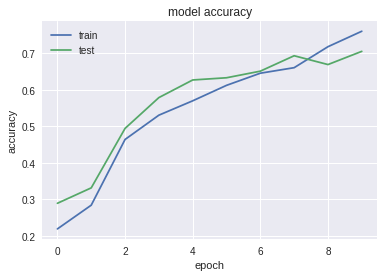

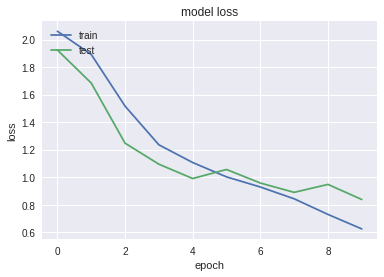

In [93]:
import matplotlib.pyplot as plt
import numpy

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.load_weights("weights.best.hdf5")
# Compile model (required to make predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [95]:
score = model.evaluate(x_val, y_val,
                       batch_size=32, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

206/206 [==============================] - 8s 39ms/step
Test score: 0.9977530397257759
Test accuracy: 0.7135922341670805


In [0]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [0]:
y_softmax = model.predict(x_val)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_val)):
    probs = y_val[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [98]:
print(y_test_1d)
print(y_pred_1d)

[6, 7, 5, 7, 2, 4, 6, 4, 5, 0, 4, 7, 6, 6, 7, 4, 6, 0, 4, 2, 4, 4, 6, 2, 0, 4, 4, 0, 4, 6, 5, 3, 2, 7, 2, 2, 6, 4, 5, 5, 6, 7, 3, 3, 5, 6, 5, 6, 6, 4, 3, 0, 5, 3, 1, 2, 5, 7, 7, 1, 2, 6, 6, 6, 6, 6, 5, 2, 5, 2, 7, 3, 7, 0, 2, 1, 6, 2, 6, 7, 6, 2, 2, 6, 7, 4, 7, 5, 4, 2, 5, 5, 2, 3, 1, 4, 4, 4, 7, 3, 5, 5, 1, 1, 0, 6, 4, 6, 5, 6, 0, 0, 0, 0, 6, 5, 6, 4, 4, 5, 6, 2, 3, 2, 3, 4, 5, 4, 4, 6, 6, 6, 0, 2, 3, 0, 2, 1, 4, 1, 4, 2, 6, 3, 4, 7, 5, 5, 0, 6, 4, 5, 3, 5, 6, 6, 5, 5, 6, 6, 1, 4, 3, 3, 3, 7, 6, 0, 4, 6, 7, 2, 6, 0, 4, 6, 4, 3, 0, 6, 6, 7, 4, 0, 2, 6, 0, 4, 3, 2, 6, 3, 5, 5, 6, 6, 4, 4, 3, 6, 1, 6, 4, 3, 7, 6]
[6, 7, 5, 4, 2, 4, 6, 4, 2, 4, 4, 7, 5, 6, 7, 4, 6, 3, 4, 6, 4, 4, 6, 3, 2, 4, 4, 2, 4, 6, 3, 3, 2, 7, 2, 0, 6, 4, 5, 5, 6, 7, 3, 3, 5, 6, 5, 6, 6, 4, 0, 0, 3, 0, 7, 2, 5, 7, 2, 7, 2, 0, 6, 6, 6, 6, 5, 2, 5, 2, 7, 0, 7, 0, 3, 3, 6, 2, 6, 7, 6, 2, 2, 6, 7, 4, 7, 5, 4, 2, 5, 6, 2, 3, 7, 4, 3, 4, 7, 0, 5, 3, 7, 4, 3, 6, 4, 6, 5, 6, 0, 4, 0, 3, 6, 5, 6, 4, 0, 5, 6, 2, 3, 2, 3, 4, 5,

## Simple LSTM


In [2]:
from keras.models import Sequential
from keras.layers import *

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)


model_lstm = Sequential()
model_lstm.add(Embedding(100000, 100, input_length=MAX_SEQUENCE_LENGTH))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(8, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm.summary()

Using TensorFlow backend.


NameError: ignored

In [0]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [1]:
history = model_lstm.fit(x_train, y_train,
                    batch_size=16,
                    epochs=2,
                    verbose=1,
                    validation_split=0.2, callbacks=callbacks_list)

NameError: ignored

In [0]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model_lstm.load_weights("weights.best.hdf5")
# Compile model (required to make predictions)
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


### Create training and test split of the labels

In [0]:
from sklearn.model_selection import train_test_split

#split the data and labels into a test and train set
X_trainS, X_testS, y_trainS, y_testS = train_test_split(texts, labelsStruct, test_size=0.3, random_state=0)

In [0]:
#split the data and labels into a test and train set
X_trainP, X_testP, y_trainP, y_testP = train_test_split(texts, labelsPath, test_size=0.3, random_state=0)

In [0]:
#split for category texts and labels
X_trainC, X_testC, y_trainC, y_testC = train_test_split(cat_texts, labelsCat, test_size=0.3, random_state=0)

## Preprocessing
In this part of the notebook we are going to preprocess the data itself. The data will be tokenized, preprocessed and stored as Training and Test sets

In [0]:
from keras.preprocessing.text import Tokenizer

Once fit, the Tokenizer provides 4 attributes that you can use to query what has been learned about your documents:

*   word_counts: A dictionary of words and their counts.
*   word_docs: A dictionary of words and how many documents each appeared in.
*   word_index: A dictionary of words and their uniquely assigned integers.
*   document_count:An integer count of the total number of documents that were used to fit the Tokenizer.


[source](https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/)


In [0]:
tokenizer = Tokenizer(num_words=100000,filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')

tokenizer

tokenizer.fit_on_texts(specs_json)



x_train = tokenizer.texts_to_matrix(X_train)
x_test = tokenizer.texts_to_matrix(X_test)

--------------------------------

In [84]:
x_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [85]:
x_test

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [0]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

encoder = LabelBinarizer()
encoder.fit(labelsStruct)
y_train = encoder.transform(Y_Struct_train)
y_test = encoder.transform(Y_Struct_test)

In [94]:
y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [95]:
len(x_train[0])

100000

In [96]:
print('y_train shape:', y_train.shape)

y_train shape: (808, 8)


In [97]:
print('x_train shape:', x_train.shape)

x_train shape: (808, 100000)


In [0]:
batch_size = 32
epochs = 2

---------------------------------------------------------------

## Model Architecture
In this section of the notebook the actual deep learning model is designed and the architecture presented before the actual training of it will take place.

In [0]:
model = Sequential()
model.add(Embedding(10000, 128, input_length=100000))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(8, activation='softmax',name = 'softmax_layer'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [114]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100000, 128)       1280000   
_________________________________________________________________
dropout_26 (Dropout)         (None, 100000, 128)       0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 99996, 64)         41024     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 24999, 64)         0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 24999, 64)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
__________

In [0]:
history = model.fit(x_train, y_train,
                    batch_size=8,
                    epochs=3,
                    verbose=1,
                    validation_split=0.2)

Train on 646 samples, validate on 162 samples
Epoch 1/3
  8/646 [..............................] - ETA: 1:48:40 - loss: 2.0601 - acc: 0.3750

In [0]:
model2 = Sequential()
model2.add(Dense(2048, input_shape=(100000,), activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1024, activation='sigmoid'))
model2.add(Dropout(0.2))
model2.add(Dense(8, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [110]:
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 2048)              204802048 
_________________________________________________________________
dropout_21 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_22 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 8200      
Total params: 206,908,424
Trainable params: 206,908,424
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history2 = model2.fit(x_train, y_train,
                    batch_size=32,
                    epochs=15,
                    verbose=1,
                    validation_split=0.2)

### first training

In [0]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [0]:
score = model2.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [0]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=128)


In [0]:
loss_and_metrics = model2.evaluate(x_test, y_test, batch_size=128)


### Use Model

In [0]:
classes = model.predict(x_test, batch_size=128)


In [0]:
classes2 = model2.predict(x_test, batch_size=128)

### Evaluation